<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Models/5%25_no_address_imbalance_2_Class_Garabge_ResNetCIFAR_Train_From_Scratch_Basic_50_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR Image Classification using ResNet


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import sys
import os
import random
import numpy as np
import torch

In [16]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset, random_split, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.notebook import tqdm

In [17]:
seed = 42
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch's random seed for CPU
torch.cuda.manual_seed(seed)  # PyTorch's random seed for the current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch's random seed for all GPUs (if using multi-GPU)

# Ensure deterministic behavior on GPU (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set environment variables for further reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

### System Check

In [18]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load data

Get the mean and std for train data

Training set

mean: [0.6256342530250549, 0.5870475769042969, 0.5542739629745483]

std: [0.2797325849533081, 0.2854619324207306, 0.2984888553619385]



In [19]:
# import torch
# import numpy as np
# from torchvision import datasets, transforms
# from torch.utils.data.sampler import SubsetRandomSampler
# import os
# from PIL import Image
# from sklearn.model_selection import train_test_split
# from collections import Counter

# # Paths and config
# DATA_PATH = "/content/drive/MyDrive/two_class_garbage-dataset"

# # number of subprocesses to use for data loading
# num_workers = 0
# # how many samples per batch to load
# batch_size = 20

# print('==> Preparing data..')

# # Create the base dataset without any transforms initially
# class GarbageDataset(torch.utils.data.Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform

#         # Define classes with specific indices
#         self.classes = ['non_battery', 'battery']  # Class indices: non_battery=0, battery=1
#         self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

#         self.samples = []
#         # Walk through all files in the directory
#         for class_name in self.classes:
#             class_dir = os.path.join(root_dir, class_name)
#             class_idx = self.class_to_idx[class_name]

#             if not os.path.isdir(class_dir):
#                 print(f"Warning: Directory {class_dir} does not exist!")
#                 continue

#             for root, _, files in os.walk(class_dir):
#                 for file in files:
#                     if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                         self.samples.append((os.path.join(root, file), class_idx))

#         # Print class distribution information
#         labels = [label for _, label in self.samples]
#         class_counts = Counter(labels)
#         print(f"Dataset class distribution:")
#         for class_idx, count in class_counts.items():
#             print(f"  - {self.classes[class_idx]}: {count} samples")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, label = self.samples[idx]
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # For calculating mean and std, we need a temporary transform
# temp_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor()  # Converts to [0, 1] range
# ])

# # Create a temporary dataset with the temp transform
# temp_dataset = GarbageDataset(root_dir=DATA_PATH, transform=temp_transform)

# # Get all samples and labels for stratification
# all_samples = []
# all_labels = []
# for idx in range(len(temp_dataset)):
#     _, label = temp_dataset[idx]
#     all_labels.append(label)
#     all_samples.append(idx)

# # Print class distribution to verify data is loaded correctly
# print("Overall class distribution in dataset:")
# label_counter = Counter(all_labels)
# for class_idx, count in label_counter.items():
#     class_name = temp_dataset.classes[class_idx]
#     percentage = count / len(all_labels) * 100
#     print(f"  - {class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

# # First, perform a stratified split to separate train (80%) and evaluation (20%) data
# train_indices, eval_indices = train_test_split(
#     all_samples,
#     test_size=0.2,
#     random_state=42,
#     stratify=all_labels
# )

# # Get labels for the evaluation set for further stratified splitting
# eval_labels = [all_labels[i] for i in eval_indices]

# # Split the evaluation indices into validation and test sets (50% each of evaluation data)
# valid_indices, test_indices = train_test_split(
#     eval_indices,
#     test_size=0.5,
#     random_state=42,
#     stratify=eval_labels
# )

# print(f"Split proportions: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)} (train/valid/test)")

# # Calculate class distribution to verify stratification
# train_labels = [all_labels[i] for i in train_indices]
# valid_labels = [all_labels[i] for i in valid_indices]
# test_labels = [all_labels[i] for i in test_indices]

# print("Class distribution after stratified split:")
# for i, class_name in enumerate(temp_dataset.classes):
#     train_pct = train_labels.count(i) / len(train_labels) * 100
#     valid_pct = valid_labels.count(i) / len(valid_labels) * 100
#     test_pct = test_labels.count(i) / len(test_labels) * 100

#     print(f"{class_name} (class {i}):")
#     print(f"  - Train: {train_labels.count(i)} samples ({train_pct:.2f}%)")
#     print(f"  - Valid: {valid_labels.count(i)} samples ({valid_pct:.2f}%)")
#     print(f"  - Test:  {test_labels.count(i)} samples ({test_pct:.2f}%)")

# # Create a temporary data loader for just the training portion
# # to calculate mean and std for normalization
# temp_train_dataset = torch.utils.data.Subset(temp_dataset, train_indices)
# temp_train_loader = torch.utils.data.DataLoader(
#     temp_train_dataset, batch_size=64, shuffle=False, num_workers=num_workers
# )

# # Function to calculate mean and std
# def calculate_mean_std(loader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _ in loader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5

#     return mean, std

# print('Calculating dataset mean and std using ONLY the training set...')
# mean, std = calculate_mean_std(temp_train_loader)
# print(f'Training set mean: {mean.tolist()}, std: {std.tolist()}')

### Preprocess train, val, test data (80% train, 10% val, 10% test)

In [20]:
import torch
import numpy as np
from torchvision import datasets, transforms
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset

# Paths and config
DATA_PATH = "/content/drive/MyDrive/two_class_garbage-dataset"
num_workers = 2
batch_size = 32

print('==> Preparing data..')

# Use ImageFolder dataset with default mapping
dataset = datasets.ImageFolder(
    DATA_PATH,
    transform=None  # No transforms yet
)

# Print default class information
print("Classes:", dataset.classes)
print("Default class to index mapping:", dataset.class_to_idx)

# Get targets for stratification
targets = np.array(dataset.targets)

# Print class distribution
class_counts = Counter(targets)
print("Dataset class distribution:")
for class_name in dataset.classes:
    class_idx = dataset.class_to_idx[class_name]
    count = class_counts[class_idx]
    percentage = count / len(targets) * 100
    print(f"  - {class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

# Verify the first few samples
print("Verification - First few samples and their classes:")
for i in range(min(5, len(dataset.samples))):
    path, class_idx = dataset.samples[i]
    class_name = dataset.classes[class_idx]
    print(f"  Sample {i}: {path} → Class: {class_name} (index: {class_idx})")

# First split: train vs eval (80/20 split) - keeping stratified split
train_indices, eval_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,  # 20% for evaluation (will be split into val and test)
    stratify=targets,
    random_state=42
)

# Get labels for the evaluation set for further stratified splitting
eval_targets = targets[eval_indices]

# Second split: validation vs test (50/50 of the eval set, which makes 10/10 of total)
valid_indices, test_indices = train_test_split(
    eval_indices,
    test_size=0.5,  # Split eval set equally between validation and test
    stratify=eval_targets,
    random_state=42
)

print(f"Split proportions: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)} (train/valid/test)")

# Print class distribution after stratified split
train_targets = targets[train_indices]
val_targets = targets[valid_indices]
test_targets = targets[test_indices]

# Print class distribution after stratified split
print("Class distribution after stratified split:")
for class_name in dataset.classes:
    class_idx = dataset.class_to_idx[class_name]
    train_count = np.sum(train_targets == class_idx)
    val_count = np.sum(val_targets == class_idx)
    test_count = np.sum(test_targets == class_idx)

    train_pct = train_count / len(train_targets) * 100
    val_pct = val_count / len(val_targets) * 100
    test_pct = test_count / len(test_targets) * 100

    print(f"{class_name} (class {class_idx}):")
    print(f"  - Train: {train_count} samples ({train_pct:.2f}%)")
    print(f"  - Valid: {val_count} samples ({val_pct:.2f}%)")
    print(f"  - Test:  {test_count} samples ({test_pct:.2f}%)")

# Define the transforms with dataset-specific values
MEAN = [0.6256342530250549, 0.5870475769042969, 0.5542739629745483]
STD = [0.2797325849533081, 0.2854619324207306, 0.2984888553619385]

# Define transforms without data augmentation
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Custom wrapper for applying transforms
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create subsets
train_set = TransformedSubset(Subset(dataset, train_indices), transform_train)
val_set = TransformedSubset(Subset(dataset, valid_indices), transform_test)
test_set = TransformedSubset(Subset(dataset, test_indices), transform_test)

# Prepare data loaders without weighted sampler
train_loader = DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True, num_workers=num_workers  # Using standard shuffle instead of weighted sampler
)
valid_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)

print(f'Number of training samples: {len(train_set)}')
print(f'Number of validation samples: {len(val_set)}')
print(f'Number of test samples: {len(test_set)}')
print(f'Total samples: {len(dataset)}')

# Function to check batch distribution (without balancing)
def check_batch_distribution(loader, num_batches=5):
    class_counts = Counter()
    for i, (_, labels) in enumerate(loader):
        if i >= num_batches:
            break
        class_counts.update(labels.numpy())
    print("Sampled batch class distribution:", dict(class_counts))

print("Checking batch distribution (without weighted sampling):")
check_batch_distribution(train_loader)

==> Preparing data..
Classes: ['battery', 'non_battery']
Default class to index mapping: {'battery': 0, 'non_battery': 1}
Dataset class distribution:
  - battery (class 0): 944 samples (4.78%)
  - non_battery (class 1): 18786 samples (95.22%)
Verification - First few samples and their classes:
  Sample 0: /content/drive/MyDrive/two_class_garbage-dataset/battery/battery_1.jpg → Class: battery (index: 0)
  Sample 1: /content/drive/MyDrive/two_class_garbage-dataset/battery/battery_10.jpg → Class: battery (index: 0)
  Sample 2: /content/drive/MyDrive/two_class_garbage-dataset/battery/battery_100.jpg → Class: battery (index: 0)
  Sample 3: /content/drive/MyDrive/two_class_garbage-dataset/battery/battery_101.jpg → Class: battery (index: 0)
  Sample 4: /content/drive/MyDrive/two_class_garbage-dataset/battery/battery_102.jpg → Class: battery (index: 0)
Split proportions: 15784/1973/1973 (train/valid/test)
Class distribution after stratified split:
battery (class 0):
  - Train: 755 samples (4.7

## Show pictures

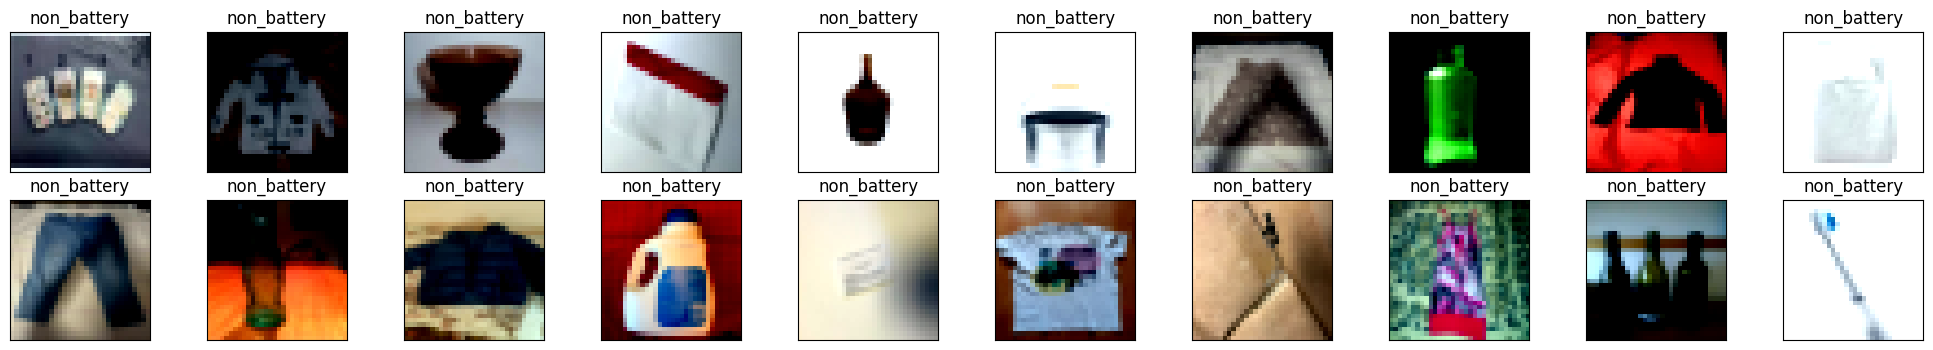

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy for display

# Use dataset.classes instead of the undefined 'classes' variable
classes = dataset.classes

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### view one image in more detail

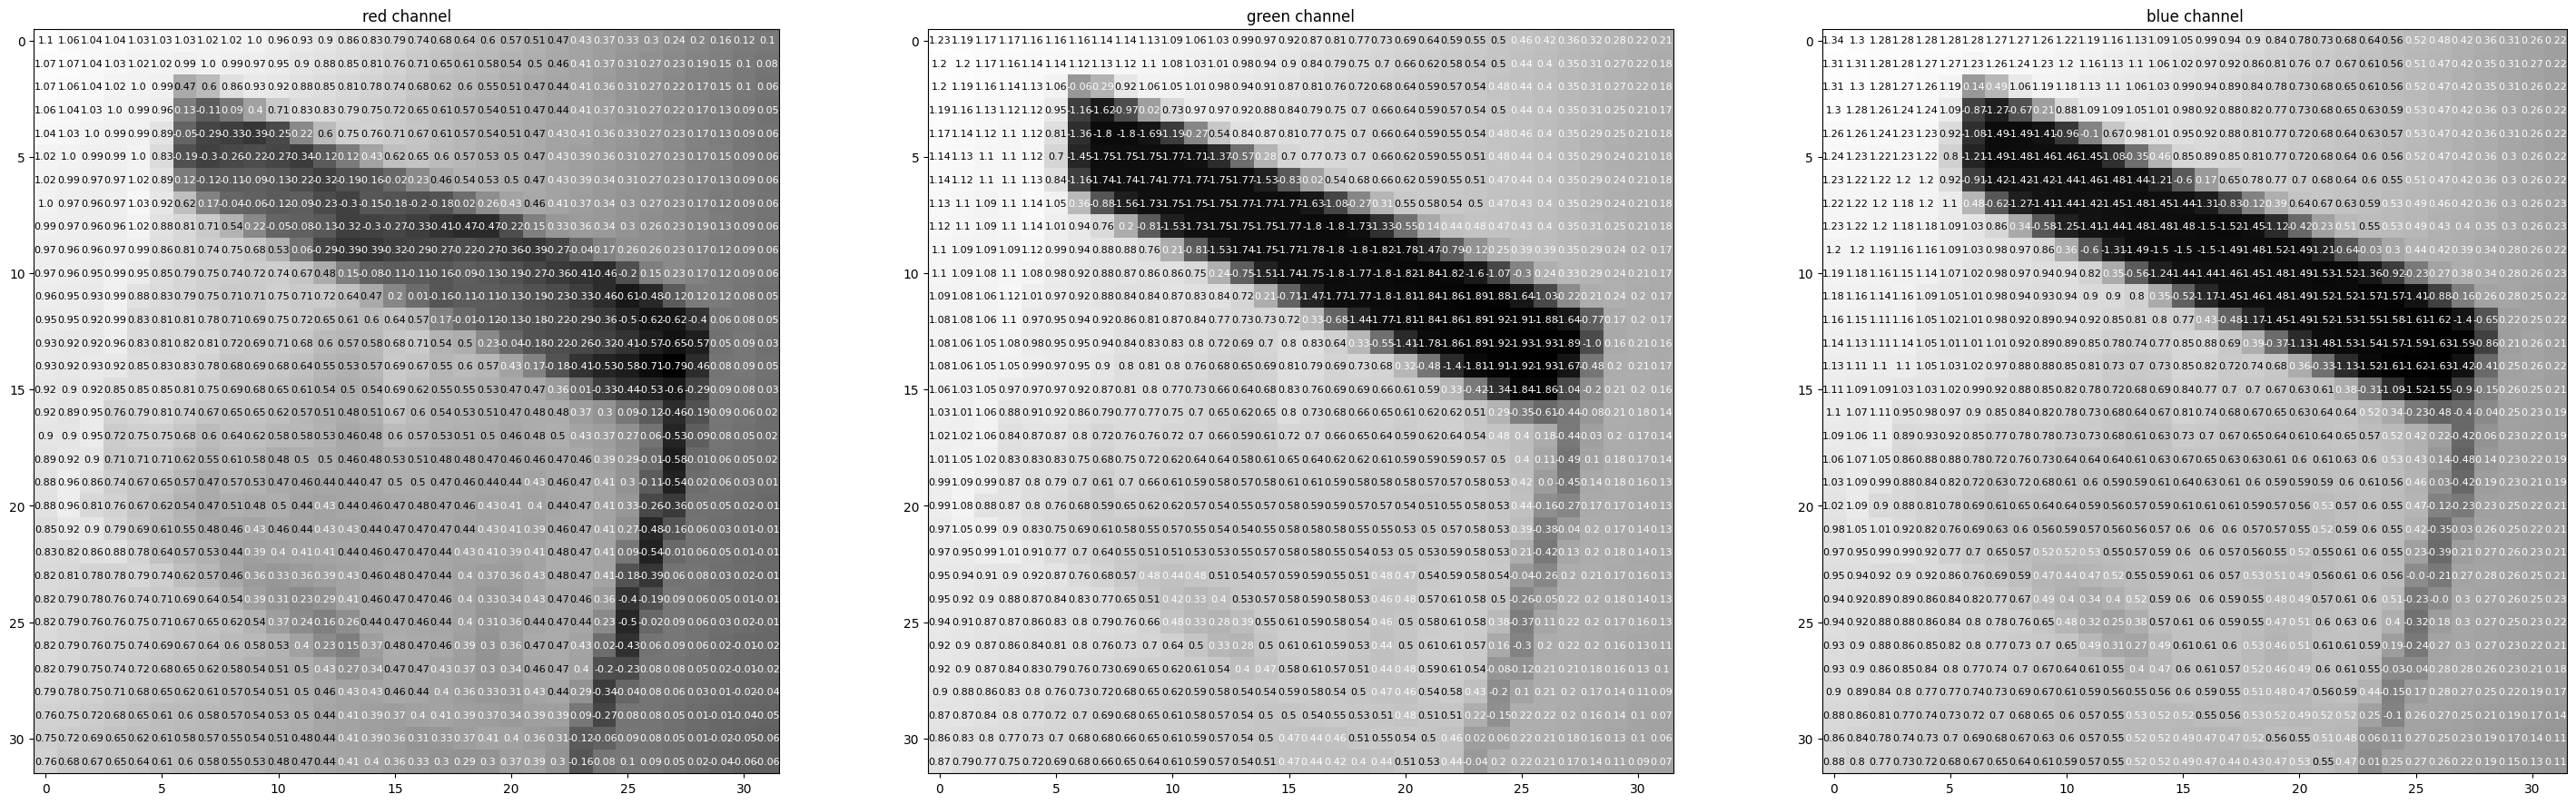

In [22]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
      horizontalalignment='center',
      verticalalignment='center', size=8,
      color='white' if img[x][y]<thresh else 'black')

### Model definition

In [23]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=2):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet18)

if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## loss

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Simply use regular CrossEntropyLoss without weights
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Print out class distribution for clarity
class_counts = Counter(train_targets)
total_samples = len(train_targets)

print("Class distribution:")
for class_name in dataset.classes:
    class_idx = dataset.class_to_idx[class_name]
    count = class_counts[class_idx]
    percentage = count / total_samples * 100
    print(f"{class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

Class distribution:
battery (class 0): 755 samples (4.78%)
non_battery (class 1): 15029 samples (95.22%)


# train

Actual class mapping from dataset: {'battery': 0, 'non_battery': 1}
Class names by index: ['battery', 'non_battery']


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1 [0/15784 (0%)]	Loss: 0.618388
Epoch: 1 [640/15784 (4%)]	Loss: 0.116691
Epoch: 1 [1280/15784 (8%)]	Loss: 0.135074
Epoch: 1 [1920/15784 (12%)]	Loss: 0.077942
Epoch: 1 [2560/15784 (16%)]	Loss: 0.105122
Epoch: 1 [3200/15784 (20%)]	Loss: 0.121056
Epoch: 1 [3840/15784 (24%)]	Loss: 0.123095
Epoch: 1 [4480/15784 (28%)]	Loss: 0.334459
Epoch: 1 [5120/15784 (32%)]	Loss: 0.269109
Epoch: 1 [5760/15784 (36%)]	Loss: 0.136046
Epoch: 1 [6400/15784 (40%)]	Loss: 0.036621
Epoch: 1 [7040/15784 (45%)]	Loss: 0.143451
Epoch: 1 [7680/15784 (49%)]	Loss: 0.216176
Epoch: 1 [8320/15784 (53%)]	Loss: 0.266923
Epoch: 1 [8960/15784 (57%)]	Loss: 0.041316
Epoch: 1 [9600/15784 (61%)]	Loss: 0.038353
Epoch: 1 [10240/15784 (65%)]	Loss: 0.440740
Epoch: 1 [10880/15784 (69%)]	Loss: 0.061492
Epoch: 1 [11520/15784 (73%)]	Loss: 0.176093
Epoch: 1 [12160/15784 (77%)]	Loss: 0.162401
Epoch: 1 [12800/15784 (81%)]	Loss: 0.291011
Epoch: 1 [13440/15784 (85%)]	Loss: 0.164561
Epoch: 1 [14080/15784 (89%)]	Loss: 0.047086
Epoch: 1 [1

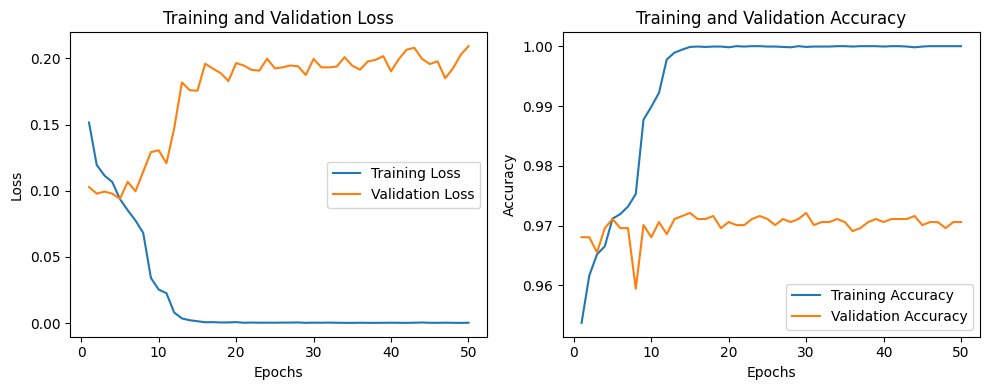

In [25]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names by index for correct reporting
class_names = [""] * len(dataset.class_to_idx)
for name, idx in dataset.class_to_idx.items():
    class_names[idx] = name

# Print actual class mapping from dataset for verification
print("Actual class mapping from dataset:", dataset.class_to_idx)
print("Class names by index:", class_names)

# Number of epochs to train the model
n_epochs = 50

# Use regular CrossEntropyLoss without weights
criterion = torch.nn.CrossEntropyLoss()

# Learning rate scheduler to reduce LR when validation performance plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Track best model and metrics
valid_loss_min = np.inf
best_epoch = 0
best_accuracy = 0  # Track accuracy

# Initialize arrays to store metrics history
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1, n_epochs+1):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Keep track of predictions and targets for metrics
    train_preds = []
    train_targets = []
    valid_preds = []
    valid_targets = []

    ###################
    # Train the model #
    ###################
    ResNet18.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = ResNet18(data)

        # Calculate the batch loss (standard cross entropy, no class weights)
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * data.size(0)

        # Get predictions for metrics
        _, preds = torch.max(output, 1)
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(target.cpu().numpy())

        # Print progress (every 20 batches)
        if batch_idx % 20 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    ######################
    # Validate the model #
    ######################
    ResNet18.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = ResNet18(data)

            # Calculate the batch loss
            loss = criterion(output, target)

            # Update average validation loss
            valid_loss += loss.item() * data.size(0)

            # Get predictions for metrics
            _, preds = torch.max(output, 1)
            valid_preds.extend(preds.cpu().numpy())
            valid_targets.extend(target.cpu().numpy())

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # Calculate metrics
    train_accuracy = accuracy_score(train_targets, train_preds)
    valid_accuracy = accuracy_score(valid_targets, valid_preds)

    # Calculate precision, recall and f1 for both classes
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        train_targets, train_preds, average=None, labels=[0, 1]
    )
    valid_precision, valid_recall, valid_f1, _ = precision_recall_fscore_support(
        valid_targets, valid_preds, average=None, labels=[0, 1]
    )

    # Calculate confusion matrices
    train_cm = confusion_matrix(train_targets, train_preds)
    valid_cm = confusion_matrix(valid_targets, valid_preds)

    # Store metrics for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    # Print training/validation statistics
    print(f'\nEpoch: {epoch}/{n_epochs}')
    print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    print(f'Training Accuracy: {train_accuracy:.4f} \tValidation Accuracy: {valid_accuracy:.4f}')

    # Print metrics for each class (using actual class mapping)
    print('\nTraining Metrics by Class:')
    print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
    print(f'{class_names[0]}\t{train_precision[0]:.4f}\t\t{train_recall[0]:.4f}\t\t{train_f1[0]:.4f}')
    print(f'{class_names[1]}\t{train_precision[1]:.4f}\t\t{train_recall[1]:.4f}\t\t{train_f1[1]:.4f}')

    print('\nValidation Metrics by Class:')
    print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
    print(f'{class_names[0]}\t{valid_precision[0]:.4f}\t\t{valid_recall[0]:.4f}\t\t{valid_f1[0]:.4f}')
    print(f'{class_names[1]}\t{valid_precision[1]:.4f}\t\t{valid_recall[1]:.4f}\t\t{valid_f1[1]:.4f}')

    # Print confusion matrices
    print("\nTraining Confusion Matrix:")
    print(train_cm)
    print("\nValidation Confusion Matrix:")
    print(valid_cm)

    # Full classification reports (using actual class mapping)
    print("\nDetailed Training Classification Report:")
    print(classification_report(train_targets, train_preds, target_names=class_names))

    print("\nDetailed Validation Classification Report:")
    print(classification_report(valid_targets, valid_preds, target_names=class_names))

    # Update learning rate based on validation loss
    scheduler.step(valid_loss)

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...')
        torch.save(ResNet18.state_dict(), '/content/drive/MyDrive/ECE661 final project/no_balance_ResNet18_2_class_garbage_train_50.pt')
        valid_loss_min = valid_loss
        best_epoch = epoch

    print('-' * 80)  # Print a line for better readability between epochs

print(f"Training complete. Best validation loss: {valid_loss_min:.6f} at epoch {best_epoch}")

# Plot training history
plt.figure(figsize=(10, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, n_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# load best

Actual class mapping from dataset: {'battery': 0, 'non_battery': 1}
Class names by index: ['battery', 'non_battery']
Test Accuracy: 0.9711

Test Metrics by Class:
Class		Precision	Recall		F1-Score
battery	0.6979		0.7053		0.7016
non_battery	0.9851		0.9846		0.9848

Test Confusion Matrix:
[[  67   28]
 [  29 1849]]

Detailed Test Classification Report:
              precision    recall  f1-score   support

     battery       0.70      0.71      0.70        95
 non_battery       0.99      0.98      0.98      1878

    accuracy                           0.97      1973
   macro avg       0.84      0.84      0.84      1973
weighted avg       0.97      0.97      0.97      1973



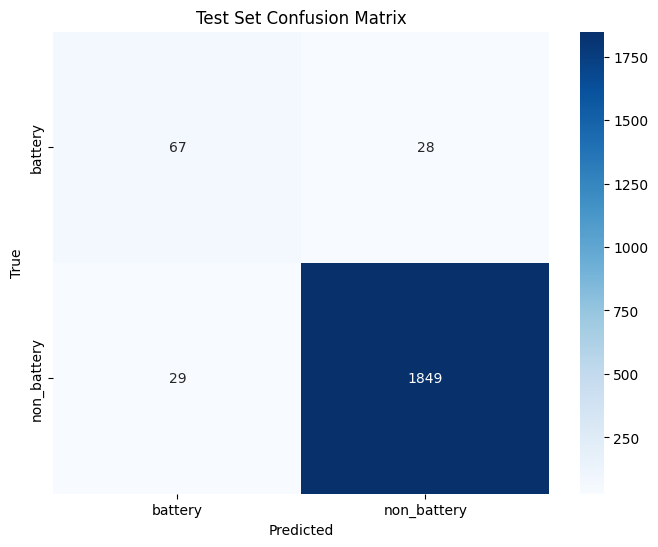

Basic confusion matrix:
[[  67   28]
 [  29 1849]]

Additional Metrics:

For battery (battery) class as positive:
Specificity (True Negative Rate): 0.9846
Sensitivity (True Positive Rate): 0.7053
Precision: 0.6979
F1 Score: 0.7016

For non_battery (non_battery) class as positive:
Specificity (True Negative Rate): 0.7053
Sensitivity (True Positive Rate): 0.9846
Precision: 0.9851
F1 Score: 0.9848

Verification with sklearn metrics:
Battery precision: 0.6979
Battery recall: 0.7053
Battery F1: 0.7016
Non-battery precision: 0.9851
Non-battery recall: 0.9846
Non-battery F1: 0.9848


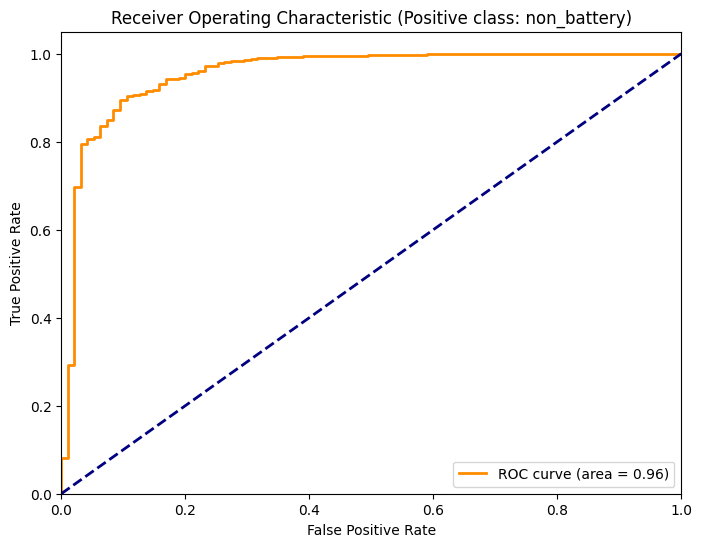

In [26]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names by index for correct reporting
class_names = [""] * len(dataset.class_to_idx)
for name, idx in dataset.class_to_idx.items():
    class_names[idx] = name

# Print actual class mapping from dataset for verification
print("Actual class mapping from dataset:", dataset.class_to_idx)
print("Class names by index:", class_names)

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Load the saved model
model_path = '/content/drive/MyDrive/ECE661 final project/no_balance_ResNet18_2_class_garbage_train_50.pt'  # Path to the saved model

# Initialize the model with the same architecture
ResNet18 = ResNet(BasicBlock, [2,2,2,2], num_classes=2)

# Handle loading from DataParallel model if needed
if train_on_gpu:
    ResNet18 = ResNet18.cuda()
    state_dict = torch.load(model_path)
    # If the model was saved with DataParallel
    if list(state_dict.keys())[0].startswith('module.'):
        ResNet18 = torch.nn.DataParallel(ResNet18)
        ResNet18.load_state_dict(state_dict)
    else:
        ResNet18.load_state_dict(state_dict)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    # If the model was saved with DataParallel but we're loading on CPU
    if list(state_dict.keys())[0].startswith('module.'):
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove 'module.' prefix
            new_state_dict[name] = v
        ResNet18.load_state_dict(new_state_dict)
    else:
        ResNet18.load_state_dict(state_dict)

# Set model to evaluation mode
ResNet18.eval()

# Initialize variables to store predictions and ground truth
test_preds = []
test_targets = []

# Evaluate on test set
with torch.no_grad():  # Disable gradient calculation for evaluation
    for data, target in test_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = ResNet18(data)

        # Get predictions
        _, preds = torch.max(output, 1)

        # Collect all predictions and targets
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(target.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_targets, test_preds, average=None, labels=[0, 1]
)
test_cm = confusion_matrix(test_targets, test_preds)

# Print results
print(f'Test Accuracy: {test_accuracy:.4f}')

print('\nTest Metrics by Class:')
print(f'Class\t\tPrecision\tRecall\t\tF1-Score')
print(f'{class_names[0]}\t{test_precision[0]:.4f}\t\t{test_recall[0]:.4f}\t\t{test_f1[0]:.4f}')
print(f'{class_names[1]}\t{test_precision[1]:.4f}\t\t{test_recall[1]:.4f}\t\t{test_f1[1]:.4f}')

print("\nTest Confusion Matrix:")
print(test_cm)

print("\nDetailed Test Classification Report:")
print(classification_report(test_targets, test_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.savefig('test_confusion_matrix.png')
plt.show()

# Calculate and print additional metrics for both classes correctly
# First, get the basic confusion matrix
cm = confusion_matrix(test_targets, test_preds)
print("Basic confusion matrix:")
print(cm)

# Properly interpret the confusion matrix
# For class 0 (battery) as positive
tp_battery = cm[0, 0]  # True positives for battery
fp_battery = cm[1, 0]  # False positives for battery
fn_battery = cm[0, 1]  # False negatives for battery
tn_battery = cm[1, 1]  # True negatives for battery

# Calculate metrics for battery class
sensitivity_battery = tp_battery / (tp_battery + fn_battery) if (tp_battery + fn_battery) > 0 else 0
specificity_battery = tn_battery / (tn_battery + fp_battery) if (tn_battery + fp_battery) > 0 else 0
precision_battery = tp_battery / (tp_battery + fp_battery) if (tp_battery + fp_battery) > 0 else 0
f1_battery = 2 * (precision_battery * sensitivity_battery) / (precision_battery + sensitivity_battery) if (precision_battery + sensitivity_battery) > 0 else 0

# For class 1 (non_battery) as positive
tp_nonbattery = cm[1, 1]  # True positives for non_battery
fp_nonbattery = cm[0, 1]  # False positives for non_battery
fn_nonbattery = cm[1, 0]  # False negatives for non_battery
tn_nonbattery = cm[0, 0]  # True negatives for non_battery

# Calculate metrics for non_battery class
sensitivity_nonbattery = tp_nonbattery / (tp_nonbattery + fn_nonbattery) if (tp_nonbattery + fn_nonbattery) > 0 else 0
specificity_nonbattery = tn_nonbattery / (tn_nonbattery + fp_nonbattery) if (tn_nonbattery + fp_nonbattery) > 0 else 0
precision_nonbattery = tp_nonbattery / (tp_nonbattery + fp_nonbattery) if (tp_nonbattery + fp_nonbattery) > 0 else 0
f1_nonbattery = 2 * (precision_nonbattery * sensitivity_nonbattery) / (precision_nonbattery + sensitivity_nonbattery) if (precision_nonbattery + sensitivity_nonbattery) > 0 else 0

# Print the metrics
print("\nAdditional Metrics:")
print(f"\nFor {class_names[0]} (battery) class as positive:")
print(f"Specificity (True Negative Rate): {specificity_battery:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_battery:.4f}")
print(f"Precision: {precision_battery:.4f}")
print(f"F1 Score: {f1_battery:.4f}")

print(f"\nFor {class_names[1]} (non_battery) class as positive:")
print(f"Specificity (True Negative Rate): {specificity_nonbattery:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity_nonbattery:.4f}")
print(f"Precision: {precision_nonbattery:.4f}")
print(f"F1 Score: {f1_nonbattery:.4f}")

# Verify that our calculated metrics match those from sklearn's classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

print("\nVerification with sklearn metrics:")
print(f"Battery precision: {precision_score(test_targets, test_preds, pos_label=0):.4f}")
print(f"Battery recall: {recall_score(test_targets, test_preds, pos_label=0):.4f}")
print(f"Battery F1: {f1_score(test_targets, test_preds, pos_label=0):.4f}")
print(f"Non-battery precision: {precision_score(test_targets, test_preds, pos_label=1):.4f}")
print(f"Non-battery recall: {recall_score(test_targets, test_preds, pos_label=1):.4f}")
print(f"Non-battery F1: {f1_score(test_targets, test_preds, pos_label=1):.4f}")

# Plot ROC curve for standard evaluation (no imbalance handling)
if True:  # Set to True if want to compute ROC curve
    from sklearn.metrics import roc_curve, auc

    # We need to rerun predictions to get probabilities
    test_probs = []
    with torch.no_grad():
        for data, _ in test_loader:
            if train_on_gpu:
                data = data.cuda()
            output = ResNet18(data)
            probs = torch.nn.functional.softmax(output, dim=1)
            test_probs.extend(probs[:, 1].cpu().numpy())  # Probability for class 1

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(test_targets, test_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Positive class: {class_names[1]})')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()


Battery Class (Class 0) TPR-FPR Analysis:
Target TPR     Actual TPR     FPR            Threshold      
------------------------------------------------------------
0.99           0.9895         0.7077         0.0014         
0.95           0.9474         0.1896         0.0340         
0.90           0.8947         0.0958         0.0821         
0.85           0.8526         0.0825         0.1055         
0.80           0.8000         0.0453         0.1997         


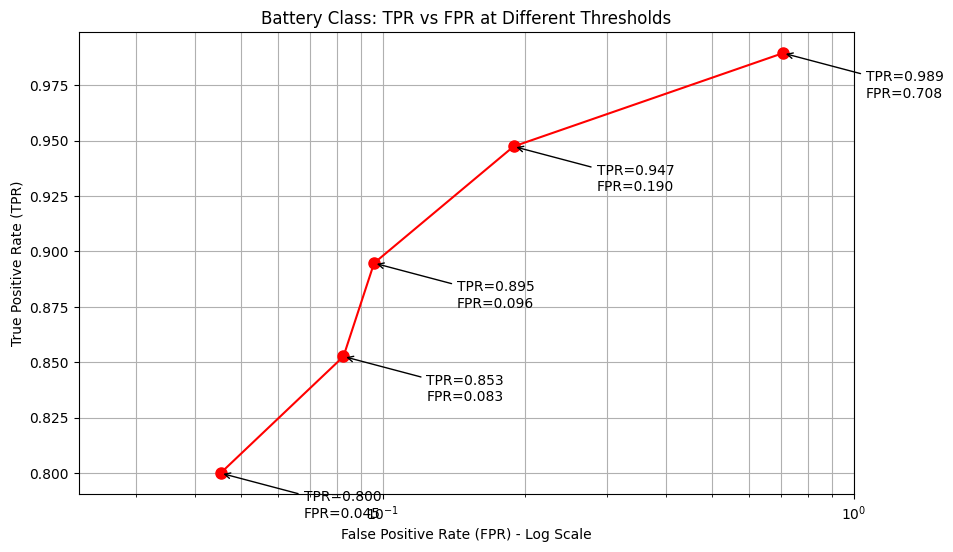

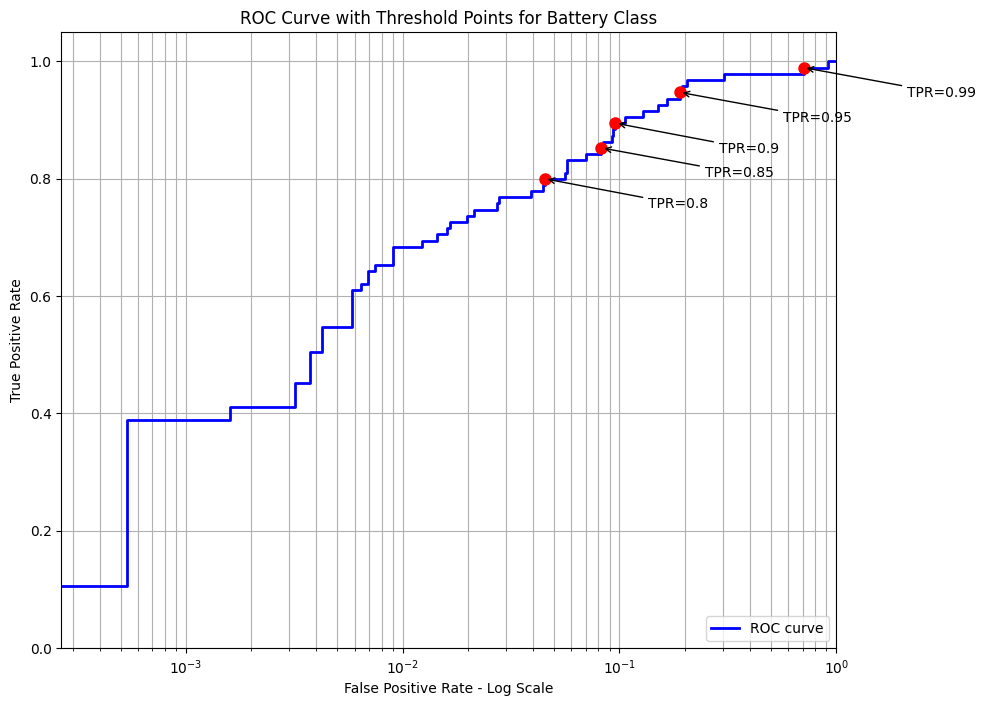


Summary of Battery Class TPR-FPR Relationship:
Target TPR     Actual TPR     FPR            TPR/FPR Ratio  
------------------------------------------------------------
0.99           0.9895         0.7077         1.3982         
0.95           0.9474         0.1896         4.9976         
0.90           0.8947         0.0958         9.3351         
0.85           0.8526         0.0825         10.3306        
0.80           0.8000         0.0453         17.6753        


In [27]:
import torch
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Set model to evaluation mode
ResNet18.eval()

# First, collect all predictions and ground truth
all_targets = []
all_probs = []

# Get probabilities from the model
with torch.no_grad():
    for data, target in test_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = ResNet18(data)

        # Convert to probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Store probabilities and targets
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_targets = np.array(all_targets)

# Extract probability for the battery class (assuming it's class 0)
battery_probs = all_probs[:, 0]

# List of target TPRs for the battery class
target_tprs = [0.99, 0.95, 0.90, 0.85, 0.80]

# Function to find threshold for a target TPR
def find_threshold_for_tpr(y_true, y_score, target_tpr, positive_class=0):
    # Convert to binary classification problem for battery vs non-battery
    binary_y_true = (y_true == positive_class).astype(int)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)

    # Find the index where TPR is closest to our target
    idx = np.argmin(np.abs(tpr - target_tpr))

    return thresholds[idx], fpr[idx], tpr[idx]

# Store TPR and FPR results
results = []

print("\nBattery Class (Class 0) TPR-FPR Analysis:")
print(f"{'Target TPR':<15}{'Actual TPR':<15}{'FPR':<15}{'Threshold':<15}")
print("-" * 60)

# Calculate thresholds and corresponding FPR for each target TPR
for target_tpr in target_tprs:
    threshold, fpr, actual_tpr = find_threshold_for_tpr(all_targets, battery_probs, target_tpr)
    results.append((target_tpr, actual_tpr, fpr, threshold))
    print(f"{target_tpr:<15.2f}{actual_tpr:<15.4f}{fpr:<15.4f}{threshold:<15.4f}")

# Plot TPR vs FPR relationship with log scale for FPR
plt.figure(figsize=(10, 6))
tprs = [r[1] for r in results]
fprs = [r[2] for r in results]

# Plot the points
plt.semilogx(fprs, tprs, 'ro-', markersize=8)  # Using semilogx for log scale on x-axis

# Add data labels
for i, (target_tpr, actual_tpr, fpr, _) in enumerate(results):
    plt.annotate(f"TPR={actual_tpr:.3f}\nFPR={fpr:.3f}",
                 xy=(fpr, actual_tpr),
                 xytext=(fpr*1.5, actual_tpr-0.02),  # Adjusted for log scale
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.xlabel('False Positive Rate (FPR) - Log Scale')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Battery Class: TPR vs FPR at Different Thresholds')
plt.grid(True, which="both", ls="-")  # Add gridlines for both major and minor ticks
plt.xlim([min(fprs)*0.5, 1.0])  # Adjusted x-limit for log scale
plt.savefig('battery_tpr_vs_fpr_log.png')
plt.show()

# Also plot ROC curve with log scale
plt.figure(figsize=(10, 8))

# Calculate full ROC curve
binary_targets = (all_targets == 0).astype(int)  # Battery class as positive
fpr_full, tpr_full, _ = roc_curve(binary_targets, battery_probs)

# Plot ROC curve with log scale on x-axis
plt.semilogx(fpr_full, tpr_full, 'b-', lw=2, label='ROC curve')

# Plot threshold points
for i, (target_tpr, actual_tpr, fpr, _) in enumerate(results):
    plt.plot(fpr, actual_tpr, 'ro', markersize=8)
    plt.annotate(f"TPR={target_tpr}",
                 xy=(fpr, actual_tpr),
                 xytext=(fpr*3, actual_tpr-0.05),  # Adjusted for log scale
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.xlim([min(fpr_full[fpr_full > 0])*0.5, 1.0])  # Avoid log(0) error by finding minimum non-zero FPR
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate - Log Scale')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Points for Battery Class')
plt.legend(loc="lower right")
plt.grid(True, which="both", ls="-")
plt.savefig('battery_roc_with_thresholds_log.png')
plt.show()

# Create a table of results
print("\nSummary of Battery Class TPR-FPR Relationship:")
print(f"{'Target TPR':<15}{'Actual TPR':<15}{'FPR':<15}{'TPR/FPR Ratio':<15}")
print("-" * 60)

for target_tpr, actual_tpr, fpr, _ in results:
    ratio = actual_tpr / fpr if fpr > 0 else float('inf')
    print(f"{target_tpr:<15.2f}{actual_tpr:<15.4f}{fpr:<15.4f}{ratio:<15.4f}")